In [1]:
%matplotlib inline

import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt

import networkx as nx
from empiricaldist import Pmf

from warnings import simplefilter
from matplotlib.cbook import mplDeprecation
simplefilter('ignore', mplDeprecation)

# load all edges

In [2]:
def read_graph(filename):
    """Read a graph from a file.

    filename: string

    return: Graph
    """
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_ego_graph(ego):
    fb_ego = read_graph(f'facebook/{ego}.edges')
    fb_ego_copy = read_graph(f'facebook/{ego}.edges')
    for i in fb_ego_copy.nodes:
        fb_ego.add_edge(ego, i)
    return fb_ego

In [3]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz
fb = read_graph('facebook_combined.txt')
n = len(fb.nodes)
m = len(fb.edges)
n, m, nx.info(fb)

(4039, 88234, 'Graph with 4039 nodes and 88234 edges')

In [4]:
# https://snap.stanford.edu/data/facebook.tar.gz
ego_0 = read_ego_graph(ego=0)
n_0 = len(ego_0.nodes)
m_0 = len(ego_0.edges)
n_0, m_0, nx.info(ego_0)

(334, 2852, 'Graph with 334 nodes and 2852 edges')

# Visualize the network

In [5]:
def visualize_network(G, filename):
    pos = nx.spring_layout(G)
    deCent = nx.degree_centrality(G)
    node_color = [20000.0 * G.degree(v) for v in G]
    node_size = [v * 10000 for v in deCent.values()]
    plt.figure(figsize=(60,60))
    nx.draw_networkx(G, pos=pos, with_labels=False,
                     alpha=0.7,
                     node_color=node_color,
                     node_size=node_size )
    plt.axis('off')
    plt.savefig(str(filename)+'.jpg')

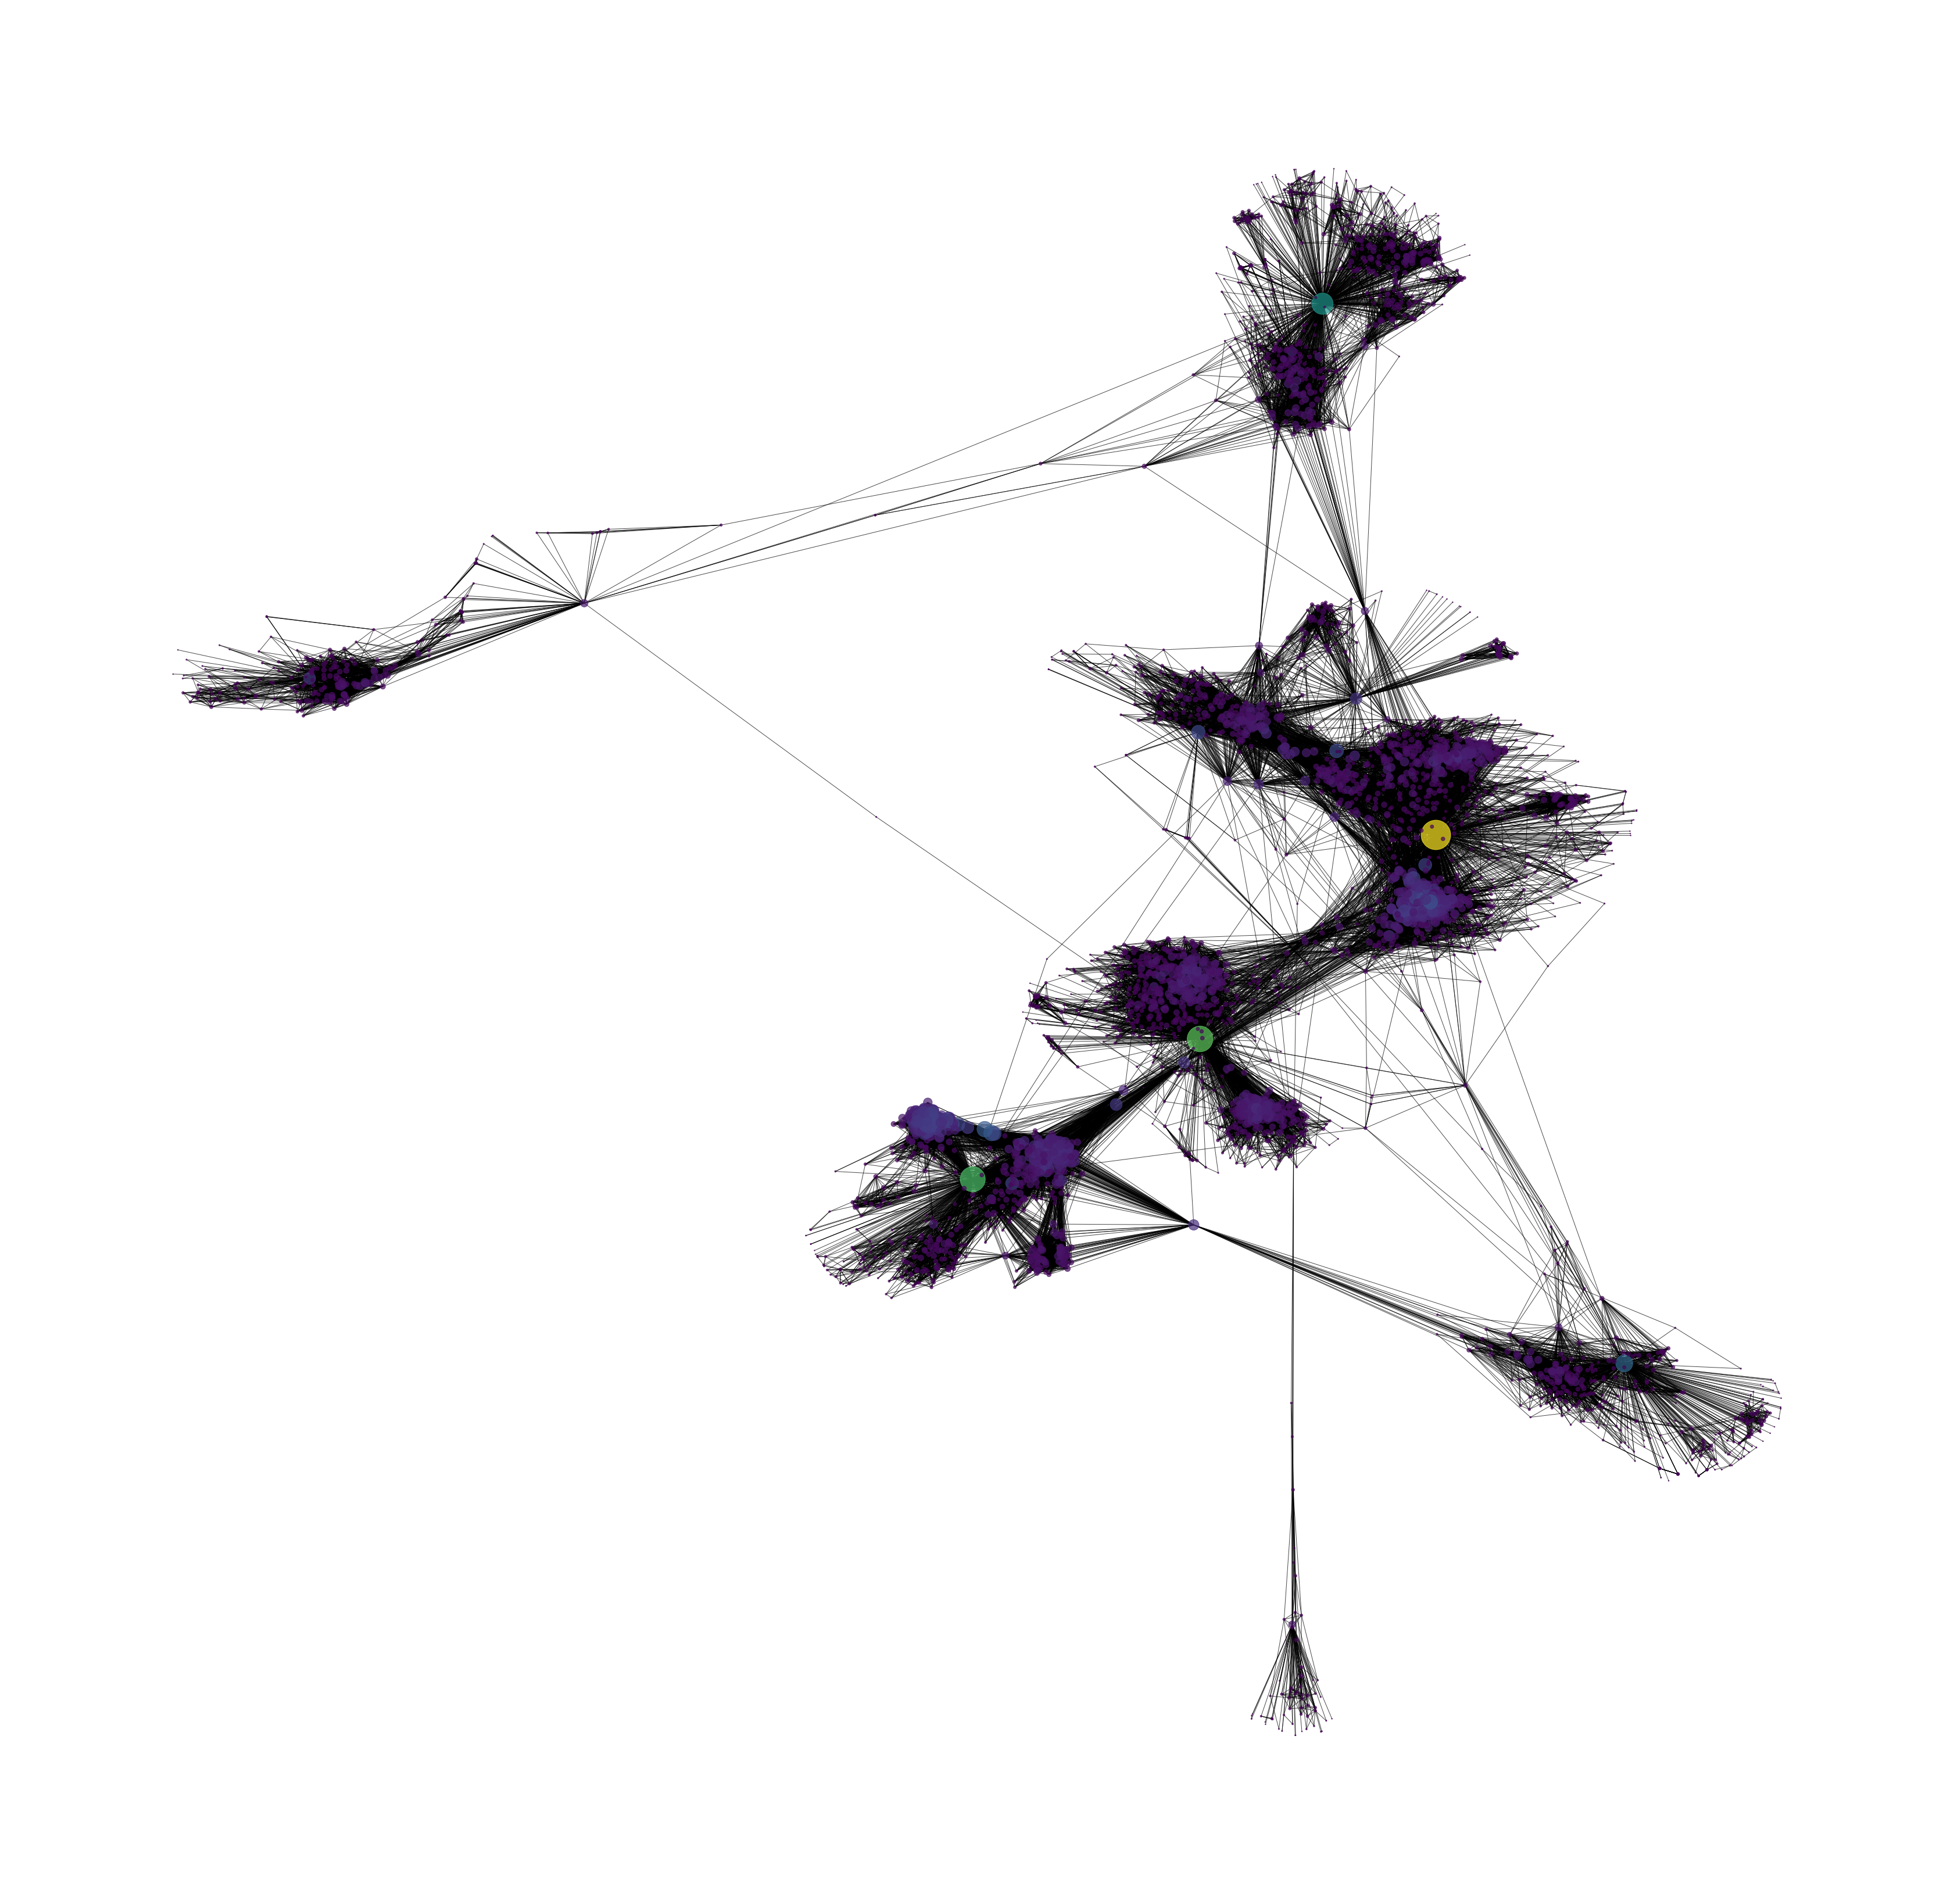

In [30]:
visualize_network(fb, filename='facebook_network')

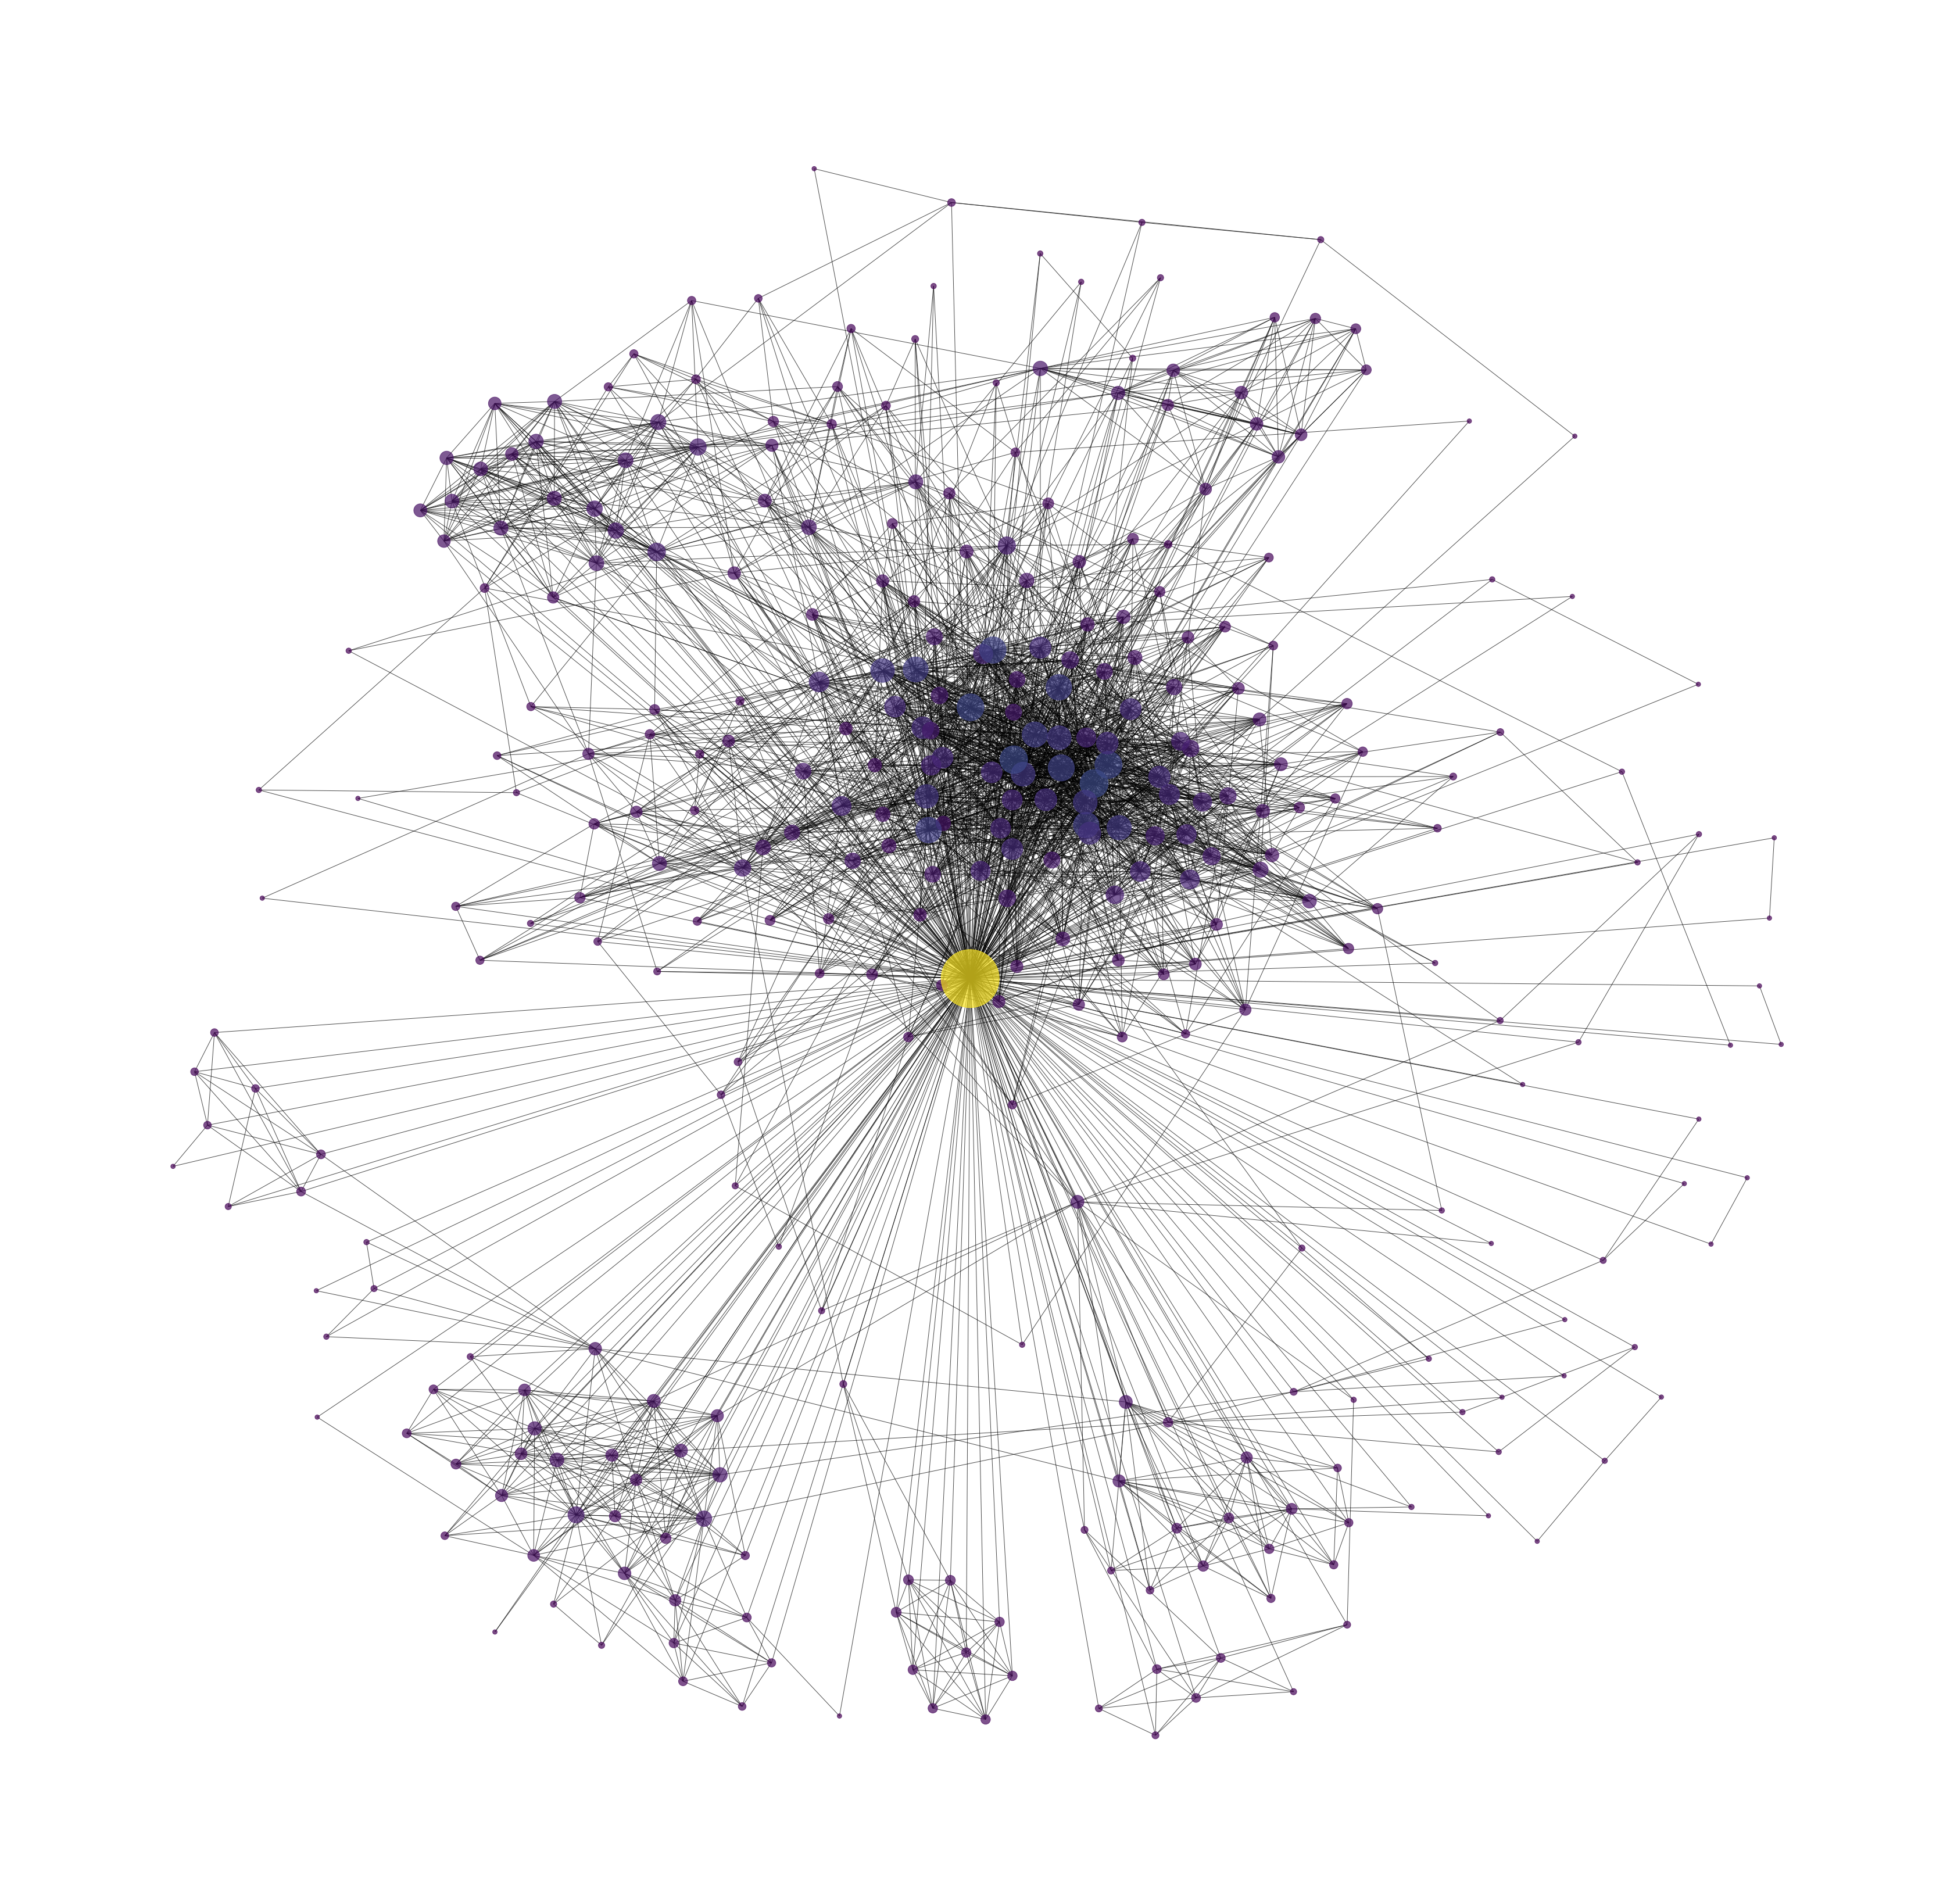

In [31]:
visualize_network(ego_0, filename='facebook_network_ego0')

In [6]:
def degrees(G):
    """List of degrees for nodes in `G`.

    G: Graph object

    returns: list of int
    """
    return [G.degree(node) for node in G]

In [7]:
# The probability for each number of degrees in the network
proba_fb = Pmf.from_seq(degrees(fb))
proba_fb

1       0.018569
2       0.024263
3       0.023026
4       0.024511
5       0.023026
          ...   
347     0.000248
547     0.000248
755     0.000248
792     0.000248
1045    0.000248
Name: , Length: 227, dtype: float64

In [8]:
proba_ego0 = Pmf.from_seq(degrees(ego_0))
proba_ego0

2      0.086826
3      0.068862
4      0.053892
5      0.032934
6      0.047904
7      0.053892
8      0.047904
9      0.044910
10     0.038922
11     0.035928
12     0.020958
13     0.035928
14     0.035928
15     0.023952
16     0.038922
17     0.026946
18     0.023952
19     0.014970
20     0.020958
21     0.017964
22     0.011976
23     0.008982
24     0.014970
25     0.011976
26     0.011976
27     0.011976
28     0.011976
30     0.005988
31     0.005988
32     0.002994
34     0.005988
36     0.005988
37     0.008982
38     0.005988
39     0.008982
40     0.002994
41     0.002994
43     0.008982
44     0.005988
45     0.002994
46     0.002994
47     0.005988
48     0.002994
49     0.002994
55     0.002994
56     0.002994
57     0.008982
59     0.002994
62     0.002994
63     0.002994
65     0.008982
68     0.002994
69     0.002994
72     0.002994
73     0.002994
76     0.002994
78     0.002994
333    0.002994
Name: , dtype: float64

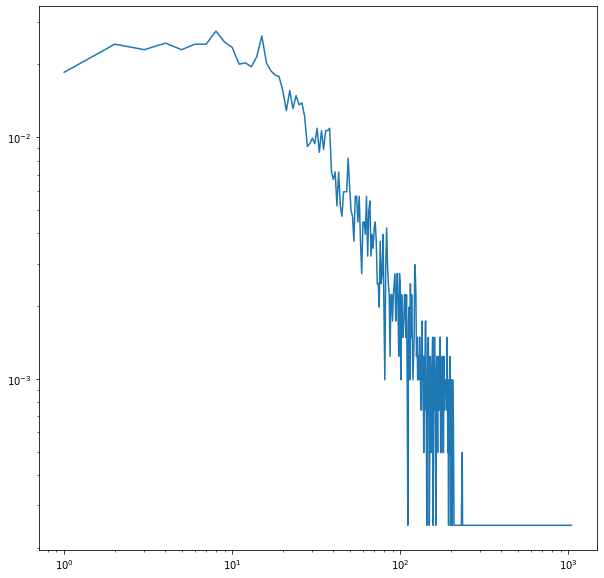

In [9]:
plt.figure(figsize=(10, 10))
proba_fb.plot(loglog=True)
plt.savefig('loglog_for_facebook_network')

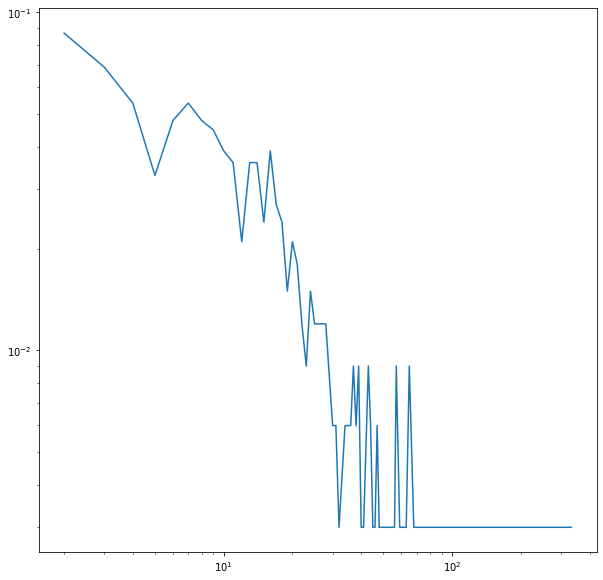

In [10]:
plt.figure(figsize=(10, 10))
proba_ego0.plot(loglog=True)
plt.savefig('loglog_for_ego0_network')

## Generate BA model

In [11]:
def _random_subset(repeated_nodes, k):
    """Select a random subset of nodes without repeating.

    repeated_nodes: list of nodes
    k: size of set

    returns: set of nodes
    """
    targets = set()
    while len(targets) < k:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

def barabasi_albert_graph(n, k, seed=None):
    """Constructs a BA graph.

    n: number of nodes
    k: number of edges for each new node
    seed: random seen
    """
    if seed is not None:
        random.seed(seed)

    G = nx.empty_graph(k)
    targets = set(range(k))
    repeated_nodes = []

    for source in range(k, n):

        G.add_edges_from(zip([source]*k, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * k)

        targets = _random_subset(repeated_nodes, k)

    return G

In [12]:
n = len(fb)
m = len(fb.edges())
k = int(round(m/n))
n, m, k

(4039, 88234, 22)

In [13]:
ba = barabasi_albert_graph(n=len(fb), k=int(round(len(fb.edges())/len(fb))), seed=15)
nx.info(ba)

'Graph with 4039 nodes and 88374 edges'

## zipf distribution

In [14]:
zipf_sample = np.random.zipf(a=1.0001, size=len(fb.nodes))
zipf_sample.size

4039

In [15]:
pmf_ba = Pmf.from_seq(degrees(ba))
pmf = Pmf.from_seq(zipf_sample)

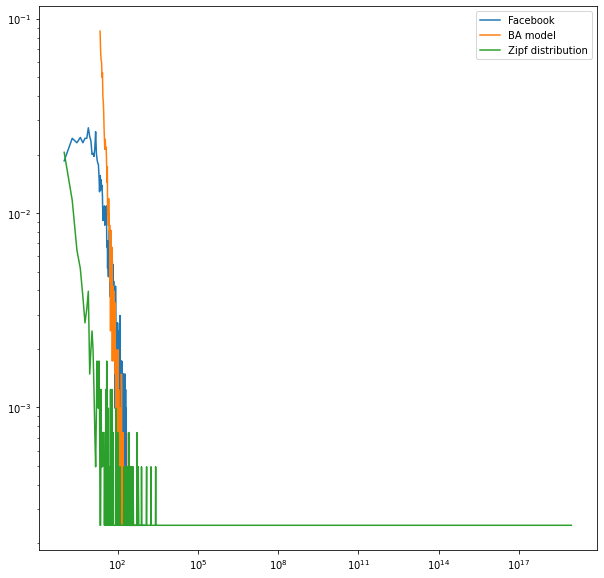

In [16]:
plt.figure(figsize=(10,10))
proba_fb.plot(loglog=True, label='Facebook')
pmf_ba.plot(loglog=True, label='BA model')
pmf.plot(loglog=True, label='Zipf distribution')
plt.legend()
plt.savefig('Compare 3 Distribution.jpg')

## Compare the fitting of different distribution

In [18]:
fit = powerlaw.Fit(proba_fb)
fit.alpha, fit.sigma, fit.xmin

Calculating best minimal value for power law fit


(1.8126478275905782, 0.06326454757544205, 0.0009903441445902451)

In [29]:
fit.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)

(4953.4939583227015, 0.0)

In [30]:
fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)

(-1.7277385627961732, 0.08403510651060356)

In [31]:
fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

(2.6068749130893476, 0.009137273309372815)